# OpenFOAM Potential Flow Simulation

This tutorial demonstrates how to run an [OpenFOAM](https://openfoam.org/) (Open-source Field Operation And Manipulation) potential flow simulation using Camber. Specifically, we'll use the `potentialFoam` solver to simulate potential flow around a cylinder, which is a classic benchmark problem in computational fluid dynamics.

Potential flow theory assumes the fluid is:
- **Incompressible**: Constant density throughout the flow
- **Irrotational**: No vorticity in the flow field
- **Inviscid**: No viscous effects (no boundary layers)
- **Steady**: Time-independent flow field

This example demonstrates fundamental OpenFOAM features including:
- Non-orthogonal mesh generation using blockMesh
- Analytical solution comparison for validation
- Dynamic code generation for complex geometries
- Post-processing and visualization of potential flow results

The complete OpenFOAM case includes:
- **Case management scripts**: `Allrun` and `Allclean` for automated workflow execution
- **Initial conditions**: `0.orig/` directory with velocity (`U`) and pressure (`p`) boundary conditions
- **System configuration**: `system/` directory containing mesh generation (`blockMeshDict`), simulation control (`controlDict`), numerical schemes (`fvSchemes`, `fvSolution`), and parallel decomposition (`decomposeParDict`) settings
- **License file**: Standard OpenFOAM case licensing information

Unlike viscous flow, potential flow produces smooth streamlines with no flow separation or boundary layers, making it ideal for validation and providing initial conditions for more complex simulations.

In [6]:
import camber


## Configure and Submit OpenFOAM Job

Here we configure and submit a `potentialFoam` simulation job for potential flow around a cylinder:

- `command="bash ./Allrun"`: Runs the complete workflow
- `engine_size="XSMALL"`: Indicates the [engine size](https://docs.cambercloud.com/docs/engines-pricing/#cpu-engine-sizes) for the simulation

The simulation workflow includes:
- **Mesh generation**: Creates a 10-block structured mesh around the cylinder using `blockMesh`
- **Potential flow solution**: Solves Laplace's equation (∇²φ = 0) for the velocity potential
- **Analytical comparison**: Generates analytical solution for validation using coded function objects
- **Post-processing**: Creates streamlines and exports results to VTK format

In [ ]:
# Create and submit potentialFoam simulation job
openfoam_job = camber.openfoam.create_job(
    command="bash ./Allrun",  # Execute complete potentialFoam workflow
    engine_size="XSMALL"                   # Small engine sufficient for this demo
)


## Check Job Status

Monitor the [job status](https://docs.cambercloud.com/docs/reference/job-attributes/#status) to track the simulation progress:

In [ ]:
openfoam_job.status

'RUNNING'


## Monitor Job Execution

To monitor job execution in real-time, use the `read_logs()` method to view the OpenFOAM solver output and simulation progress (please, stand by patiently until the output appears):

In [ ]:
# Read real-time logs from the potentialFoam simulation
# This shows mesh generation, pressure equation convergence, and analytical comparison
openfoam_job.read_logs()

Job logs are online at this momment, so you cannot use options head_lines or tail_lines.
---
Restore 0/ from 0.orig/
Running blockMesh on /home/camber/workdir
Running potentialFoam on /home/camber/workdir
Running postProcess on /home/camber/workdir



## Install Visualization Dependencies

Install PyVista for advanced 3D visualization and VTK file processing:

In [ ]:
# Install PyVista for VTK file processing and 3D visualization
%pip install -qq pyvista

Note: you may need to restart the kernel to use updated packages.



## Analyze and Visualize Potential Flow Results

Once the `potentialFoam` simulation is complete, we can analyze and visualize the potential flow results. This section:

1. **Loads VTK output files**: Reads the OpenFOAM results exported in VTK format for post-processing
2. **Processes mesh and boundary data**: Extracts the computational mesh and cylinder boundary geometry
3. **Handles velocity field data**: Retrieves velocity vectors from the potential flow solution
4. **Creates cylinder mask**: Uses computational geometry to exclude interior points of the cylinder
5. **Interpolates to regular grid**: Converts unstructured CFD data to a regular grid for visualization
6. **Generates streamline plot**: Creates visualization showing smooth potential flow streamlines

The potential flow visualization demonstrates key characteristics:
- **Smooth streamlines**: No flow separation or vorticity due to inviscid assumption
- **Symmetrical flow**: Perfect fore-aft symmetry around the cylinder
- **No boundary layers**: Fluid can slip along the cylinder surface (no viscosity)
- **Conservation of mass**: Streamlines compress around the cylinder, increasing velocity
- **Analytical validation**: Results can be compared directly with theoretical solution

Note: This idealized flow differs significantly from real viscous flow, which would show boundary layers, flow separation, and wake formation behind the cylinder.

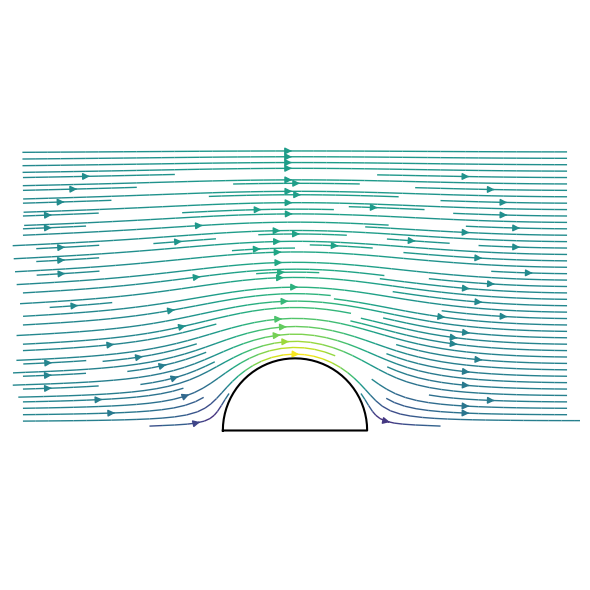

In [ ]:
# Import required libraries for data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from scipy.interpolate import griddata
from matplotlib.path import Path
from scipy.spatial import ConvexHull

# ============================================================================
# LOAD AND PROCESS VTK DATA FROM POTENTIALFOAM SIMULATION
# ============================================================================

# Load the potential flow solution and cylinder boundary
# AFTER `from matplotlib.path import Path` …
from pathlib import Path as FS        # avoid the name clash with matplotlib.Path
run = next(d for d in FS('VTK').iterdir() if d.is_dir())  # first sub-folder
mesh     = pv.read(run / 'internal.vtu')
cylinder = pv.read(run / 'boundary' / 'cylinder.vtp')

# Extract cell centers and velocity data from the potential flow solution
cells = mesh.cell_centers()
centres = cells.points[:, :2]          # 2D cell-center coordinates (N×2)
U = mesh.cell_data["U"][:, :2]         # Velocity components from potential flow [u, v] (N×2)

# ============================================================================
# CREATE CYLINDER BOUNDARY POLYGON FOR MASKING
# ============================================================================

# Extract 2D cylinder boundary points and create convex hull
c2d = cylinder.points[:, :2]
hull = ConvexHull(c2d)
poly = c2d[hull.vertices]              # Ordered boundary vertices
poly_path = Path(poly)                 # Create matplotlib Path for inside/outside tests

# Remove cell centers that are inside the cylinder body
keep = ~poly_path.contains_points(centres)
centres, U = centres[keep], U[keep]

# ============================================================================
# INTERPOLATE TO REGULAR GRID FOR STREAMLINE VISUALIZATION
# ============================================================================

# Create regular rectangular grid for streamline plotting
nx = ny = 300  # Grid resolution
xi = np.linspace(centres[:,0].min(), centres[:,0].max(), nx)
yi = np.linspace(centres[:,1].min(), centres[:,1].max(), ny)
X, Y = np.meshgrid(xi, yi)

# Interpolate velocity components from unstructured to structured grid
u = griddata(centres, U[:,0], (X, Y), method='linear')  # x-velocity component
v = griddata(centres, U[:,1], (X, Y), method='linear')  # y-velocity component

# Apply cylinder mask to grid (remove points inside cylinder)
inside = poly_path.contains_points(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)
u[inside] = v[inside] = np.nan  # Set interior points to NaN
speed = np.hypot(u, v)              # Calculate velocity magnitude

# ============================================================================
# CREATE POTENTIAL FLOW STREAMLINE VISUALIZATION
# ============================================================================

# Create streamline plot showing smooth potential flow patterns
plt.figure(figsize=(6, 6))
plt.streamplot(X, Y, u, v, 
               color=speed,           # Color streamlines by velocity magnitude
               cmap='viridis',        # Use viridis colormap
               density=1.5,           # Streamline density
               linewidth=1)           # Line thickness

# Draw cylinder outline
poly_closed = np.vstack([poly, poly[0]])   # Close the polygon
plt.plot(poly_closed[:,0], poly_closed[:,1], 'k', lw=1.5)

# Format plot for clean presentation
plt.axis('equal')      # Equal aspect ratio to preserve geometry
plt.axis('off')        # Hide axes for cleaner scientific visualization
plt.tight_layout()     # Optimize layout
plt.title('Potential Flow Around Cylinder\n(Smooth streamlines, no separation)', 
          fontsize=12, pad=20)
plt.show()
